In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

CARGA

In [35]:
pd.reset_option('display.max_columns')

In [56]:
df = pd.read_csv('dataset-uci.csv')
print("--- Estado Inicial ---")
print(f"Dimensiones del dataset: {df.shape}")
print(f"Conteo de clases en Gallstone (Original): {df['Gallstone Status'].value_counts().to_dict()}")

--- Estado Inicial ---
Dimensiones del dataset: (319, 39)
Conteo de clases en Gallstone (Original): {0: 161, 1: 158}


DEFINICIÓN DE VARIABLES

In [57]:
# Variable objetivo
y = df['Gallstone Status']
# Variables predictoras (quitamos la columna Gallstone)
X = df.drop('Gallstone Status', axis=1)

In [58]:
categorical_cols = ['Gender', 
                    'Comorbidity', 
                    'Coronary Artery Disease (CAD)', 
                    'Hypothyroidism', 
                    'Hyperlipidemia', 
                    'Diabetes Mellitus (DM)', 
                    'Hepatic Fat Accumulation (HFA)']

# Las numéricas son todas las que NO están en la lista de arriba
numerical_cols = [col for col in X.columns if col not in categorical_cols]

print(f"\nVariables Numéricas detectadas: {len(numerical_cols)}")
print(f"Variables Categóricas detectadas: {len(categorical_cols)}")
print(numerical_cols)



Variables Numéricas detectadas: 31
Variables Categóricas detectadas: 7
['Age', 'Height', 'Weight', 'Body Mass Index (BMI)', 'Total Body Water (TBW)', 'Extracellular Water (ECW)', 'Intracellular Water (ICW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)', 'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)', 'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)', 'Visceral Muscle Area (VMA) (Kg)', 'Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 'Triglyceride', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)', 'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']


In [47]:
conteo_nulos = df.isnull().sum()
print(conteo_nulos)

Gallstone Status                                  0
Age                                               0
Gender                                            0
Comorbidity                                       0
Coronary Artery Disease (CAD)                     0
Hypothyroidism                                    0
Hyperlipidemia                                    0
Diabetes Mellitus (DM)                            0
Height                                            0
Weight                                            0
Body Mass Index (BMI)                             0
Total Body Water (TBW)                            0
Extracellular Water (ECW)                         0
Intracellular Water (ICW)                         0
Extracellular Fluid/Total Body Water (ECF/TBW)    0
Total Body Fat Ratio (TBFR) (%)                   0
Lean Mass (LM) (%)                                0
Body Protein Content (Protein) (%)                0
Visceral Fat Rating (VFR)                         0
Bone Mass (B

no necesitamos imputación porque no hay nulos
CODIFICACIÓN

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 39 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Gallstone Status                                319 non-null    int64  
 1   Age                                             319 non-null    int64  
 2   Gender                                          319 non-null    int64  
 3   Comorbidity                                     319 non-null    int64  
 4   Coronary Artery Disease (CAD)                   319 non-null    int64  
 5   Hypothyroidism                                  319 non-null    int64  
 6   Hyperlipidemia                                  319 non-null    int64  
 7   Diabetes Mellitus (DM)                          319 non-null    int64  
 8   Height                                          319 non-null    int64  
 9   Weight                                     

In [59]:
df = pd.get_dummies(
    df, 
    columns=['Hepatic Fat Accumulation (HFA)'],  # La columna a transformar
    prefix='HFA',                                # Prefijo para las nuevas columnas (ej: HFA_1, HFA_2)
    drop_first=True,                             # IMPORTANTE: Elimina la primera columna (HFA_0) para evitar redundancia
    dtype=int                                    # Asegura que sean 0 y 1 (no True/False)
)

# Verificamos
print("Nuevas columnas creadas:", [col for col in df.columns if 'HFA' in col])

Nuevas columnas creadas: ['HFA_1', 'HFA_2', 'HFA_3', 'HFA_4']


SPLIT

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

REMOVER OUTLIERS

In [61]:
# =============================================================================
# LIMPIEZA DE OUTLIERS: REEMPLAZO POR MEDIANA
# Estrategia: Si un valor está fuera de rango IQR, lo volvemos mediana para no perder la fila
# por la poca cantidad de datos.
# =============================================================================

cols_a_limpiar = [
    'Age', 'Weight', 'Body Mass Index (BMI)', 'Total Body Water (TBW)',
    'Extracellular Water (ECW)', 'Intracellular Water (ICW)',
    'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Body Protein Content (Protein) (%)',
    'Visceral Fat Rating (VFR)', 'Muscle Mass (MM)', 'Obesity (%)',
    'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)', 'Glucose',
    'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)',
    'High Density Lipoprotein (HDL)', 'Triglyceride',
    'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)',
    'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)',
    'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D'
]
# Aseguramos que existan en el dataframe actual
cols_existentes = [c for c in cols_a_limpiar if c in X_train.columns]

def imputar_outliers_con_mediana(df_datos, columnas):
    df_clean = df_datos.copy()
    print(f"--- REEMPLAZANDO OUTLIERS POR LA MEDIANA ---")
    
    total_reemplazos = 0
    
    for col in columnas:
        # 1. Calculamos límites normales
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # 2. Identificamos las celdas que se salen
        mask_outliers = (df_clean[col] < lower_limit) | (df_clean[col] > upper_limit)
        n_outliers = mask_outliers.sum()
        
        if n_outliers > 0:
            # 3. Calculamos la mediana (usando solo los datos "sanos" para no contaminarla)
            mediana_sana = df_clean.loc[~mask_outliers, col].median()
            
            # 4. Reemplazamos esos valores locos por la mediana
            df_clean.loc[mask_outliers, col] = mediana_sana
            total_reemplazos += n_outliers
            # print(f" -> {col}: {n_outliers} corregidos a {mediana_sana:.2f}")
            
    print(f"Listo! Se corrigieron {total_reemplazos} valores atípicos en total.")
    print(f"Filas conservadas: {len(df_clean)} (100% de los pacientes)")
    
    return df_clean

# Aplicamos
X_train_clean = imputar_outliers_con_mediana(X_train, cols_existentes)
y_train_clean = y_train 


--- REEMPLAZANDO OUTLIERS POR LA MEDIANA ---
Listo! Se corrigieron 182 valores atípicos en total.
Filas conservadas: 255 (100% de los pacientes)


ESCALAMIENTO

In [62]:
cols_to_scale = [
    'Age', 'Height', 'Weight', 'Body Mass Index (BMI)', 
    'Total Body Water (TBW)', 'Extracellular Water (ECW)', 
    'Intracellular Water (ICW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 
    'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 
    'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)', 
    'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)', 
    'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)', 
    'Visceral Muscle Area (VMA) (Kg)', 'Glucose', 
    'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 
    'High Density Lipoprotein (HDL)', 'Triglyceride', 
    'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 
    'Alkaline Phosphatase (ALP)', 'Creatinine', 
    'Glomerular Filtration Rate (GFR)', 'C-Reactive Protein (CRP)', 
    'Hemoglobin (HGB)', 'Vitamin D'
]

In [ ]:
X_train_final = X_train_clean.copy()
X_test_final = X_test.copy()

cols_a_escalar =  [c for c in cols_to_scale if c in X_train_clean.columns]

print(f"Escalando {len(cols_a_escalar)} variables...")

scaler = StandardScaler()
X_train_final[cols_a_escalar] = scaler.fit_transform(X_train_final[cols_a_escalar])

X_test_final[cols_a_escalar] = scaler.transform(X_test_final[cols_a_escalar])

print("Escalamiento completado!")

Escalando 26 variables...
Escalamiento completado!


SELECCIÓN DE VARIABLES

Anova

In [65]:
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier

In [66]:
selector_anova = SelectKBest(score_func=f_classif, k='all')
selector_anova.fit(X_train_final, y_train)

p_values = selector_anova.pvalues_

cols_anova = X_train_final.columns[p_values < 0.05]

print(cols_anova.tolist())

['Gender', 'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Extracellular Water (ECW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Bone Mass (BM)', 'Total Fat Content (TFC)', 'High Density Lipoprotein (HDL)', 'Aspartat Aminotransferaz (AST)', 'Creatinine', 'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']


RFECV

In [ ]:
rf_base = RandomForestClassifier(n_estimators=50, random_state=100)

selector_rfecv = RFECV(estimator=rf_base, step=1, cv=3, scoring='accuracy')
selector_rfecv.fit(X_train_final, y_train)

cols_rfecv = X_train_final.columns[selector_rfecv.support_]

print(cols_rfecv.tolist())

['Age', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Height', 'Weight', 'Body Mass Index (BMI)', 'Total Body Water (TBW)', 'Extracellular Water (ECW)', 'Intracellular Water (ICW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)', 'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)', 'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)', 'Visceral Muscle Area (VMA) (Kg)', 'Hepatic Fat Accumulation (HFA)', 'Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 'Triglyceride', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)', 'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']


In [70]:
print(len(cols_anova))
print(len(cols_rfecv))

15
36


ENTRENAMIENTO

In [69]:
X_train_anova = X_train_final[cols_anova]
X_test_anova = X_test_final[cols_anova]

X_train_rfecv = X_train_final[cols_rfecv]
X_test_rfecv = X_test_final[cols_rfecv]

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def obtener_resultados(nombre_metodo, cols_seleccionadas):
    # 1. Filtramos las columnas
    X_tr = X_train_final[cols_seleccionadas]
    X_te = X_test_final[cols_seleccionadas]
    
    resultados = []
    
    # --- MODELOS ---
    modelos = [
        ("Logística", LogisticRegression(random_state=100, max_iter=2000)),
        ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=100))
    ]
    
    for nombre_modelo, modelo in modelos:
        # Entrenar
        modelo.fit(X_tr, y_train_clean)
        # Predecir
        pred = modelo.predict(X_te)
        
        # Guardar métricas ya formateadas como porcentaje
        resultados.append({
            'Selección': nombre_metodo,
            'Modelo': nombre_modelo,
            'Accuracy': f"{accuracy_score(y_test, pred):.2%}",   # Ej: 92.10%
            'Precision': f"{precision_score(y_test, pred, zero_division=0):.2%}",
            'Recall': f"{recall_score(y_test, pred, zero_division=0):.2%}",
            'F1-Score': f"{f1_score(y_test, pred, zero_division=0):.2%}"
        })
        
    return resultados

# --- EJECUCIÓN ---
lista_final = []
lista_final.extend(obtener_resultados("ANOVA", cols_anova))
lista_final.extend(obtener_resultados("RFECV", cols_rfecv))

# --- CREAR TABLA ---
df_bonito = pd.DataFrame(lista_final)

print("\n" + "="*85)
print(f"{'COMPARACIÓN FINAL DE MODELOS':^85}") # Centrado
print("="*85)

print(df_bonito.to_string(index=False, justify='center', col_space=12))

print("="*85)
print("\n-> Accuracy:  Porcentaje total de aciertos.")
print("-> Recall:    Capacidad de detectar a los enfermos (IMPORTANTE).")
print("-> F1-Score:  El equilibrio entre los dos anteriores.\n")


                            COMPARACIÓN FINAL DE MODELOS                             
 Selección       Modelo      Accuracy    Precision      Recall      F1-Score  
   ANOVA         Logística    89.06%       90.32%       87.50%       88.89%   
   ANOVA     Random Forest    76.56%       75.76%       78.12%       76.92%   
   RFECV         Logística    87.50%       87.50%       87.50%       87.50%   
   RFECV     Random Forest    75.00%       76.67%       71.88%       74.19%   

-> Accuracy:  Porcentaje total de aciertos.
-> Recall:    Capacidad de detectar a los enfermos (IMPORTANTE).
-> F1-Score:  El equilibrio entre los dos anteriores.



✅ Gráficos generados. Busca la ventana de gráficos.


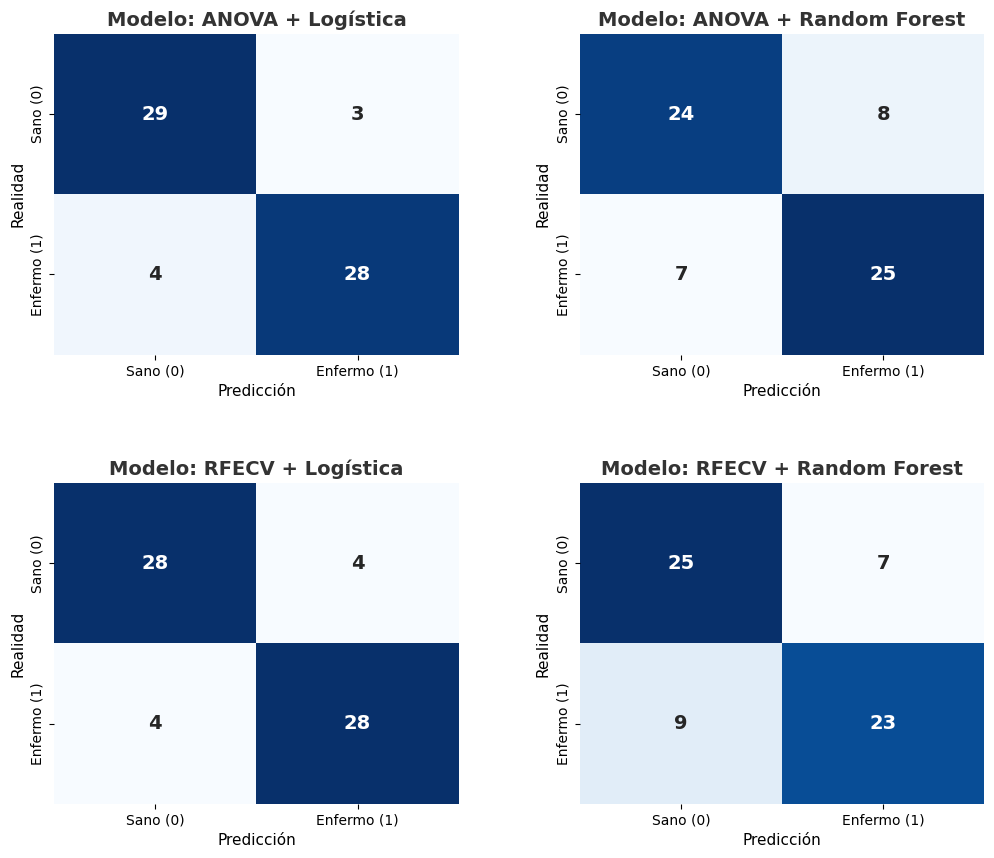

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- CONFIGURACIÓN DE NOMBRES PARA QUE SE ENTIENDA ---
# 0 = Negativo (Sano / No tiene cálculos)
# 1 = Positivo (Enfermo / Sí tiene cálculos)
etiquetas = ['Sano (0)', 'Enfermo (1)']

def graficar_matrices(cols_anova, cols_rfecv):
    
    # Preparamos el terreno: una figura con 4 espacios (2 filas, 2 columnas)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3) # Espacio entre gráficas
    
    # Definimos los 4 competidores para recorrerlos
    escenarios = [
        ("ANOVA + Logística", cols_anova, LogisticRegression(random_state=100, max_iter=2000)),
        ("ANOVA + Random Forest", cols_anova, RandomForestClassifier(n_estimators=100, random_state=100)),
        ("RFECV + Logística", cols_rfecv, LogisticRegression(random_state=100, max_iter=2000)),
        ("RFECV + Random Forest", cols_rfecv, RandomForestClassifier(n_estimators=100, random_state=100))
    ]
    
    # Recorremos cada escenario y dibujamos su matriz
    for i, (nombre, cols, modelo) in enumerate(escenarios):
        # 1. Filtramos y Entrenamos (rápido)
        X_tr = X_train_final[cols]
        X_te = X_test_final[cols]
        modelo.fit(X_tr, y_train_clean)
        
        # 2. Predecimos
        y_pred = modelo.predict(X_te)
        
        # 3. Calculamos la matriz
        cm = confusion_matrix(y_test, y_pred)
        
        # 4. DIBUJAMOS (El mapa de calor)
        ax = axes[i//2, i%2] # Ubicación en la cuadrícula
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    xticklabels=etiquetas, yticklabels=etiquetas, ax=ax,
                    annot_kws={"size": 14, "weight": "bold"}) # Números grandes
        
        ax.set_title(f"Modelo: {nombre}", fontsize=14, fontweight='bold', color='#333333')
        ax.set_ylabel('Realidad', fontsize=11)
        ax.set_xlabel('Predicción', fontsize=11)

    plt.show()

# --- EJECUTAR ---
graficar_matrices(cols_anova, cols_rfecv)